In [1]:
# given 100 point sines with random freq and phase
# with a sliding input window of N=40, predict the next point

# why so poor, random almost?

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

# might need to comment this out if you don't have a GPU
# perhaps unecessary in general, but I haven't found a way to make it work!
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

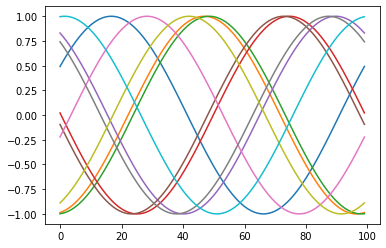

In [90]:
def gen_random_sine(n_points=100):
    frequency = random.random() * 3 + 1
    frequency = 1
    phase_offset = random.random() * 2 * np.pi
#     phase_offset = 0
    xs = np.linspace(0.0, 2*np.pi, n_points)
    ys = np.sin(xs*frequency+phase_offset)
    return ys

# have a look at some random sine waves
for _ in range(10):
    ys = gen_random_sine()
    plt.plot(ys)

In [114]:
# gen train / test data

def sliding_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

ws = []
for i in range(100):
    ws.extend(sliding_window(gen_random_sine(), 41))
    if i == 0:
        print(len(ws))
ws = np.array(ws)

# keep the first 40 points [0..39] for the input window and last [40] to be predicted
xs, ys = zip(*[(w[:40], w[40]) for w in ws])
xs, ys = np.array(xs), np.array(ys)


x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33)
x_train = x_train.reshape(x_train.shape + (1, ))
x_test = x_test.reshape(x_test.shape + (1, ))

x_train.shape, y_train.shape, x_test.shape, y_test.shape


60


((4020, 40, 1), (4020,), (1980, 40, 1), (1980,))

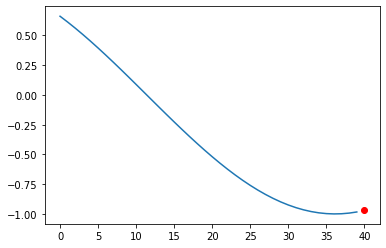

In [92]:
# examine one x,y pair
plt.plot(x_train[0])
plt.scatter([40], [y_train[0]], c='r')

In [41]:
def plot_training_history(history, model):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')

    plt.show()
    
    loss, accuracy  = model.evaluate(test_data, test_labels, verbose=False)
    print(f'Test loss: {loss:.3}')

    print(f'Test accuracy: {accuracy:.3}')

0/0.4012/0.0000/0.0210/0.0000 1/0.1002/0.0000/0.0088/0.0000 2/0.0637/0.0000/0.0035/0.0000 3/0.0463/0.0000/0.0037/0.0000 4/0.0344/0.0000/0.0043/0.0000 5/0.0296/0.0000/0.0012/0.0000 6/0.0247/0.0000/0.0014/0.0000 7/0.0220/0.0000/0.0033/0.0000 8/0.0197/0.0000/0.0007/0.0000 9/0.0180/0.0000/0.0014/0.0000 10/0.0169/0.0000/0.0007/0.0000 11/0.0157/0.0000/0.0014/0.0000 12/0.0138/0.0000/0.0007/0.0000 13/0.0140/0.0000/0.0022/0.0000 14/0.0134/0.0000/0.0001/0.0000 15/0.0119/0.0000/0.0007/0.0000 16/0.0124/0.0000/0.0004/0.0000 17/0.0112/0.0000/0.0003/0.0000 18/0.0116/0.0000/0.0004/0.0000 19/0.0113/0.0000/0.0014/0.0000 20/0.0102/0.0000/0.0006/0.0000 21/0.0108/0.0000/0.0016/0.0000 22/0.0102/0.0000/0.0004/0.0000 23/0.0100/0.0000/0.0002/0.0000 24/0.0101/0.0000/0.0007/0.0000 25/0.0095/0.0000/0.0008/0.0000 26/0.0091/0.0000/0.0003/0.0000 27/0.0094/0.0000/0.0016/0.0000 28/0.0089/0.0000/0.0003/0.0000 29/0.0088/0.0000/0.0010/0.0000 30/0.0086/0.0000/0.0003/0.0000 31/0.0082/0.0000/0.0002/0.0000 32/0.0079/0.0000/0

262/0.0042/0.0000/0.0004/0.0000 263/0.0043/0.0000/0.0002/0.0000 264/0.0044/0.0000/0.0003/0.0000 265/0.0046/0.0000/0.0003/0.0000 266/0.0045/0.0000/0.0002/0.0000 267/0.0043/0.0000/0.0006/0.0000 268/0.0046/0.0000/0.0006/0.0000 269/0.0047/0.0000/0.0005/0.0000 270/0.0044/0.0000/0.0001/0.0000 271/0.0043/0.0000/0.0003/0.0000 272/0.0042/0.0000/0.0001/0.0000 273/0.0043/0.0000/0.0002/0.0000 274/0.0044/0.0000/0.0008/0.0000 275/0.0046/0.0000/0.0001/0.0000 276/0.0045/0.0000/0.0005/0.0000 277/0.0044/0.0000/0.0001/0.0000 278/0.0044/0.0000/0.0001/0.0000 279/0.0041/0.0000/0.0002/0.0000 280/0.0046/0.0000/0.0012/0.0000 281/0.0046/0.0000/0.0001/0.0000 282/0.0043/0.0000/0.0004/0.0000 283/0.0039/0.0000/0.0003/0.0000 284/0.0044/0.0000/0.0002/0.0000 285/0.0044/0.0000/0.0000/0.0000 286/0.0044/0.0000/0.0003/0.0000 287/0.0043/0.0000/0.0001/0.0000 288/0.0043/0.0000/0.0001/0.0000 289/0.0043/0.0000/0.0004/0.0000 290/0.0044/0.0000/0.0008/0.0000 291/0.0042/0.0000/0.0003/0.0000 292/0.0044/0.0000/0.0002/0.0000 293/0.00

519/0.0046/0.0000/0.0002/0.0000 520/0.0041/0.0000/0.0009/0.0000 521/0.0044/0.0000/0.0001/0.0000 522/0.0047/0.0000/0.0001/0.0000 523/0.0044/0.0000/0.0001/0.0000 524/0.0044/0.0000/0.0004/0.0000 525/0.0045/0.0000/0.0001/0.0000 526/0.0046/0.0000/0.0002/0.0000 527/0.0043/0.0000/0.0002/0.0000 528/0.0045/0.0000/0.0004/0.0000 529/0.0045/0.0000/0.0001/0.0000 530/0.0041/0.0000/0.0001/0.0000 531/0.0044/0.0000/0.0001/0.0000 532/0.0045/0.0000/0.0001/0.0000 533/0.0042/0.0000/0.0000/0.0000 534/0.0046/0.0000/0.0005/0.0000 535/0.0045/0.0000/0.0002/0.0000 536/0.0045/0.0000/0.0002/0.0000 537/0.0044/0.0000/0.0004/0.0000 538/0.0045/0.0000/0.0001/0.0000 539/0.0042/0.0000/0.0006/0.0000 540/0.0043/0.0000/0.0003/0.0000 541/0.0044/0.0000/0.0004/0.0000 542/0.0045/0.0000/0.0003/0.0000 543/0.0043/0.0000/0.0001/0.0000 544/0.0045/0.0000/0.0001/0.0000 545/0.0045/0.0000/0.0001/0.0000 546/0.0043/0.0000/0.0000/0.0000 547/0.0042/0.0000/0.0003/0.0000 548/0.0044/0.0000/0.0002/0.0000 549/0.0043/0.0000/0.0001/0.0000 550/0.00

777/0.0043/0.0000/0.0003/0.0000 778/0.0043/0.0000/0.0006/0.0000 779/0.0045/0.0000/0.0005/0.0000 780/0.0045/0.0000/0.0001/0.0000 781/0.0042/0.0000/0.0006/0.0000 782/0.0044/0.0000/0.0005/0.0000 783/0.0043/0.0000/0.0011/0.0000 784/0.0043/0.0000/0.0007/0.0000 785/0.0047/0.0000/0.0001/0.0000 786/0.0043/0.0000/0.0000/0.0000 787/0.0045/0.0000/0.0001/0.0000 788/0.0044/0.0000/0.0002/0.0000 789/0.0042/0.0000/0.0004/0.0000 790/0.0043/0.0000/0.0003/0.0000 791/0.0042/0.0000/0.0007/0.0000 792/0.0044/0.0000/0.0003/0.0000 793/0.0043/0.0000/0.0001/0.0000 794/0.0044/0.0000/0.0000/0.0000 795/0.0042/0.0000/0.0003/0.0000 796/0.0043/0.0000/0.0005/0.0000 797/0.0048/0.0000/0.0002/0.0000 798/0.0042/0.0000/0.0005/0.0000 799/0.0044/0.0000/0.0001/0.0000 800/0.0044/0.0000/0.0003/0.0000 801/0.0042/0.0000/0.0001/0.0000 802/0.0044/0.0000/0.0001/0.0000 803/0.0045/0.0000/0.0003/0.0000 804/0.0042/0.0000/0.0001/0.0000 805/0.0043/0.0000/0.0001/0.0000 806/0.0042/0.0000/0.0002/0.0000 807/0.0043/0.0000/0.0005/0.0000 808/0.00

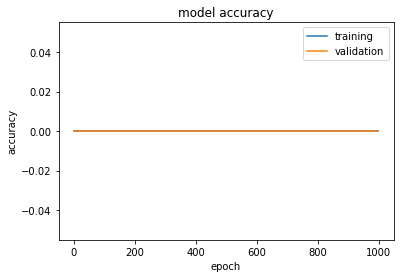

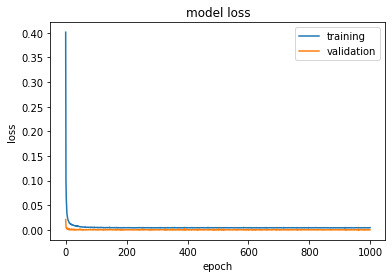

Test loss: 7.43e-05
Test accuracy: 0.000505


In [123]:
# model and train
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('{:d}/{:.4f}/{:.4f}/{:.4f}/{:.4f} '.format(epoch, logs['loss'], logs['accuracy'], 
            logs['val_loss'], logs['val_accuracy']), end='')


test_data = x_test
test_labels = y_test
model = Sequential()
model.add(Input(shape=(40,1)))
# model.add(Dense(100, activation='linear'))
# model.add(LeakyReLU(alpha=0.03))
# model.add(Dense(100, activation='tanh'))
# model.add(LeakyReLU(alpha=0.03))
model.add(Conv1D(filters=5, kernel_size=3))
model.add(Conv1D(filters=5, kernel_size=3))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(optimizer="adam", loss='mse', metrics=['accuracy'])
# model.summary()

history = model.fit(x_train, y_train, shuffle=True, batch_size=64, epochs=1000, verbose=0, validation_split=.2, callbacks=[MyCallback()])
plot_training_history(history, model)

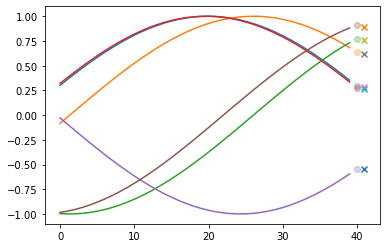

In [121]:
# use the windows from the first example
s = 10
for x in x_train[0:60:s]:
    plt.plot(x)

# plot expected predictions    
for index, y in enumerate(y_train[0:60:s]):
    plt.scatter([40], [y], alpha=0.3)

# plot actuals
yhat = model.predict(x_train[0:60:s])
for yh in yhat:
    plt.scatter([41], [yh], marker='x')

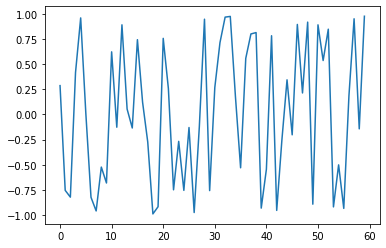

In [122]:
# given a series of input window from 1 sine curve, we should see sine as output
yhat = model.predict(x_train[0:60])
plt.plot(yhat.reshape(-1, ))